# Normal likelihoods and normal-inverse-gamma priors

Today we explore how samples from a prior distribution can be interpreted as instances of the likelihood function. Specifically, we look at how samples from a normal-inverse-gamma (NIG) distribution can be interpreted as normal distributions.

**In short:** Each sample from the NIG distribution is a pair $(x, \sigma^2)$. These values specify the mean and variance of a normal distribution and so we can think of the sample (the pair of values) as an instance of the normal distribution (which will be our likelihood function). More below.

## Normal-inverse-gamma in SciPy

Even though SciPy does have classes defined for the normal distribution (`scipy.stats.norm`) and the inverse-gamma distribution (`scipy.stats.invgamma`), it does not have one defined for the normal-inverse-gamma distribution. To help you, the functions below implement the probability density function and a sampler for the normal-inverse-gamma distribution.

In [1]:
import math
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
'''
Function definitions for the normal-inverse-gamma distribution. The parameters
of the distribution, namely mu (μ), either lambda (λ) or nu (ν), alpha (α),
beta (β), are used as defined here:

  https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution

Note that we use the symbol nu (ν) rather than lambda (λ) for the third
parameter. This is to match the notation used in the conjugate priors table on
Wikipedia:

  https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions
'''

def norminvgamma_pdf(x, sigma2, mu, nu, alpha, beta):
    '''
    The probability density function of the normal-inverse-gamma distribution at
    x (mean) and sigma2 (variance).
    '''
    return (
        sts.norm.pdf(x, loc=mu, scale=np.sqrt(sigma2 / nu)) *
        sts.invgamma.pdf(sigma2, a=alpha, scale=beta))

def norminvgamma_rvs(mu, nu, alpha, beta, size=1):
    '''
    Generate n samples from the normal-inverse-gamma distribution. This function
    returns a (size x 2) matrix where each row contains a sample, (x, sigma2).
    '''
    # Sample sigma^2 from the inverse-gamma distribution
    sigma2 = sts.invgamma.rvs(a=alpha, scale=beta, size=size)
    # Sample x from the normal distribution
    x = sts.norm.rvs(loc=mu, scale=np.sqrt(sigma2 / nu), size=size)
    return np.vstack((x, sigma2)).transpose()

## Task 1

1. Generate 10 samples from the normal-inverse-gamma (NIG) distribution with parameters as
   provided below.
   
   Each sample corresponds to the mean and variance of a normal
   distribution.
   
   With these NIG parameters, the prior 95% confidence interval for
   the mean is about [-10, 10] and for the variance [0.1, 10].
   
   In practice you would
   work the other way around: use confidence intervals (or other information) to determine values for the
   prior hyperparameters.


2. Plot the 10 normal distributions corresponding to your 10 samples. To see the functions
   clearly, plot your graphs on the domain [-15, 15].
   
   You should see that the 10 samples
   (normal distributions) are all quite different. This means the prior is quite broad
   (uncertain) over the mean and variance.

In [3]:
# Normal-inverse-gamma prior hyperparameters
mu_0 = 0        # The prior mean is centered around 0.
nu_0 = 0.054    # The smaller ν₀ is, the more uncertain we are about the prior mean.
alpha_0 = 1.12  # α₀ and β₀ control the marginal prior over the variance.
beta_0 = 0.4

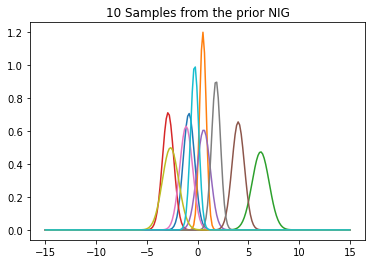

In [4]:
samples = norminvgamma_rvs(mu_0, nu_0, alpha_0, beta_0, size=10)  # YOU HAVE TO COMPLETE THIS
x = np.linspace(-15, 15, 200)

for sample in samples:
    mu, sigma2 = sample
    sigma = math.sqrt(sigma2)
    plt.plot(x, sts.norm.pdf(x, mu, sigma))

plt.title("10 Samples from the prior NIG")
plt.show()

## Task 2

Generate 1,000,000 samples from the normal-inverse-gamma prior above and calculate
approximate 95% confidence intervals over the mean and the variance using the
samples. You can use the `numpy.percentile` function for this.

Your confidence intervals should approximately match the intervals [-10, 10] and [0.1, 10].

In [5]:
samples = norminvgamma_rvs(mu_0, nu_0, alpha_0, beta_0, size=1000000)

print(np.shape(samples))

conf_int_mu = np.percentile(samples[:,0], [2.5, 97.5])
conf_int_sigma2 = np.percentile(samples[:,1], [2.5, 97.5])

print("95% confidence interval of the mean: ", conf_int_mu)
print("95% confidence interval of the variance: ", conf_int_sigma2)

(1000000, 2)
95% confidence interval of the mean:  [-9.9723234   9.93710311]
95% confidence interval of the variance:  [ 0.10137553 10.025968  ]


## Task 3
Code the equations for calculating the posterior normal-inverse-gamma hyperparameters
from the prior hyperparameters and data.

The equations are found on found [Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions) and reproduced below, using $d_i$ for a datum.
Note that $n$ is the number of data, and $\overline{d}$ is the mean of the data.

$$
\begin{align}
  \mu_{\text{post}} &= \frac{\nu_0\mu_0 + n\overline{d}}{\nu_0 + n} \\
  \nu_{\text{post}} &= \nu_0 + n \\
  \alpha_{\text{post}} &= \alpha_0 + \frac{n}{2} \\
  \beta_{\text{post}} &=
     \beta_0 +
     \frac{1}{2}\sum_{i=1}^n (d_i-\overline{d})^2 +
     \frac{n\nu_0}{\nu_0+n}\frac{(\overline{d}-\mu_0)^2}{2}
\end{align}
$$

Once you have the update equations implemented, Bayesian inference is done!

 * The likelihood function is the normal distribution with unknown mean and variance.
 * The posterior distribution is of the same type as the prior – normal-inverse-gamma.
 * The posterior parameters below give you the exact posterior normal-inverse-gamma distribution.
 * No approximation or numerical integration is needed.

In [54]:
data = np.array([1, 2, 3, 4])  # In class you will get a larger data set.
                               # This is just to get you started.
    
def update(data, mu_0, nu_0, alpha_0, beta_0):    
    mu_post = ((nu_0 * mu_0) + (len(data) * np.mean(data))/(nu_0 + len(data)))
    nu_post = nu_0 + len(data)
    alpha_post = alpha_0 + (len(data)/2.0)

    def MSE(data):
        error = 0
        for d in data:
            error += (d - len(data))**2
        return error

    beta_post = ( beta_0 + (0.5 * MSE(data)) +
                ( ( (len(data) * nu_0)/(nu_0 + len(data)) ) *
                ( ((np.mean(data) - mu_0)**2)/2) ) )
    
    return mu_post, nu_post, alpha_post, beta_post

In [55]:
mu_post, nu_post, alpha_post, beta_post = update(data, mu_0, nu_0, alpha_0, beta_0)
print(mu_post, nu_post, alpha_post, beta_post)

2.46669955599408 4.054 3.12 7.566502220029601


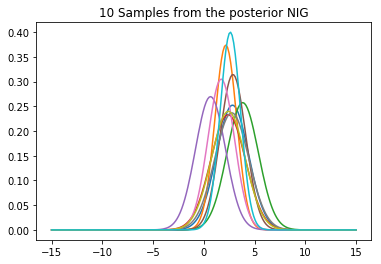

In [56]:
samples = norminvgamma_rvs(mu_post, nu_post, alpha_post, beta_post, size=10)
x = np.linspace(-15, 15, 200)

for sample in samples:
    mu, sigma2 = sample
    sigma = math.sqrt(sigma2)
    plt.plot(x, sts.norm.pdf(x, mu, sigma))

plt.title("10 Samples from the posterior NIG")
plt.show()

## Task 4

Given the information below, find reasonable values for the prior parameters of the normal-inverse-gamma distribution — μ₀, ν₀, α₀, β₀. You will be asked to provide your values for the prior hyperparameters in class, and to explain how you came up with them.

Information provided:
- The data are normally distributed. The error margins given below represent 1 standard deviation from the mean of the parameter.
- Constraint: the mean of the data is approximately 2.3 ± 0.5.
- Constraint: the variance of the data is approximately 2.75 ± 1.
- Find μ₀, ν₀, α₀, β₀ hyperparameters for the normal-inverse-gamma prior that match this information.

You can solve this problem in at least two different ways. You have to implement at least
one of these two methods. Ideally, implement both and check that your answers match.
1. Frame the information above as an optimization problem. You should design a
function that is minimized when the constraints above are all satisfied. You can do
this by creating an **objective function of the sum of squared residuals of the
constraints**. Use SciPy to find the minimum of the objective function.
For example, the mean of the data mean should be 2.3. From Wikipedia , we know
that the expected value of the mean of the normal-inverse-gamma distribution is μ₀ so we add the term $(μ₀-2.3)^2$ to the objective function. You should have 4 such
terms in your function, corresponding to the 4 constraints in the information above.
2. The constraints above give you the mean of the data mean, the standard deviation
of the data mean, the mean of the data variance, and the standard deviation of the
data variance. **Solve these 4 equations (one for each of the quantities above)
simultaneously** to find the values of the prior parameters.

**As an Optimization problem**

In [57]:
from scipy.optimize import minimize

def f(x):  #array with mu, nu, alpha, beta
    mean_resid = (x[0] - 2.3)**2
    var_resid = ( (x[3]/(x[2]-1)) - 2.75 )**2   #for alpha > 1
    mean_var_resid = ( (x[3]/float((x[2]-1)* x[1] )) - 0.5 )**2   #for alpha > 1
    var_var_resid = ( (x[3]**2/float((x[2]-1)**2 * (x[2]-2))) - 1 )**2
    
    return mean_resid + var_resid + mean_var_resid + var_var_resid

We will use the prior parameters we were previously given as our initial guess.

In [58]:
x0 = [0, 0.054, 1.12, 0.4]

cons = ({'type': 'ineq', 'fun': lambda x:  np.array(x[2] - 2) })
        
def opt(f, x0, cons, verbose=True):        
    result = minimize(f, x0, constraints=cons)
    x_opt = result.x
    # print(result)
    
    if verbose:
        print('f(%s) = %.4f' % (x_opt, f(x_opt)))
        print(f'Mu is {x_opt[0]:.2}.')
        print(f'Nu is {x_opt[1]:.2}.')
        print(f'Alpha is {x_opt[2]:.2}.')
        print(f'Beta is {x_opt[3]:.2}.')
    
    return x_opt

In [59]:
opt_x = opt(f, x0, cons)

f([  2.29999997 142.78061178 349.54578929 954.52145373]) = 1.1886
Mu is 2.3.
Nu is 1.4e+02.
Alpha is 3.5e+02.
Beta is 9.5e+02.


This seems like not quite an ideal solution... Let's try with different initial arrays.

In [60]:
for _ in range(10):
    
    x0 = np.random.uniform(0,5,4)
    opt_x = opt(f, x0, cons, False)
    print(opt_x)

[   2.30019839 1026.08024291    9.56484817   23.5570892 ]
[ 2.2999739   5.4991586   9.5671935  23.56494435]
[2.29999092e+00 1.70784532e+00 1.99999718e+00 4.27885356e-06]
[ 2.29999999  5.50016297  9.56402243 23.55100198]
[ 2.29999958e+00  4.60219581e+06  2.31102794e+04 -2.35765062e+05]
[  2.3        182.74697479 240.73451529 661.71940912]
[ 2.29999754 88.64731489  9.59125796 23.67132374]
[2.29999740e+00 3.19993782e+00 2.83425572e+04 4.53500191e+04]
[2.29998818e+00 2.56675378e+00 1.99999557e+00 6.52188889e-06]
[ 2.30000854  5.50126433  9.56289764 23.54845951]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


Seems that with random initial conditions we converge upon a pretty clear answer:

>mu = 2.3

>nu = 5.5

>alpha = 9.6

>beta = 23.5

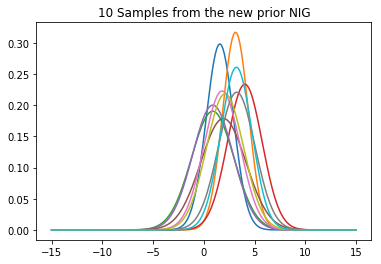

In [61]:
mu = 2.3
nu = 5.5
alpha = 9.6
beta = 23.5


samples = norminvgamma_rvs(mu, nu, alpha, beta, size=10)
x = np.linspace(-15, 15, 200)

for sample in samples:
    mu, sigma2 = sample
    sigma = math.sqrt(sigma2)
    plt.plot(x, sts.norm.pdf(x, mu, sigma))

plt.title("10 Samples from the new prior NIG")
plt.show()

In [62]:
mu_post, nu_post, alpha_post, beta_post = update(data, mu, nu, alpha, beta)
print(mu_post, nu_post, alpha_post, beta_post)

18.69165170949857 9.5 11.6 31.07892737132373


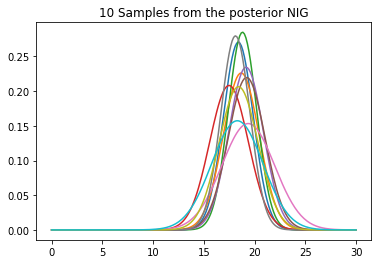

In [63]:
samples = norminvgamma_rvs(mu_post, nu_post, alpha_post, beta_post, size=10)
x = np.linspace(0, 30, 200)

for sample in samples:
    mu, sigma2 = sample
    sigma = math.sqrt(sigma2)
    plt.plot(x, sts.norm.pdf(x, mu, sigma))

plt.title("10 Samples from the posterior NIG")
plt.show()

In [66]:
samples = norminvgamma_rvs(mu_post, nu_post, alpha_post, beta_post, size=1000000)

conf_int_mu = np.percentile(samples[:,0], [2.5, 97.5])
conf_int_sigma2 = np.percentile(samples[:,1], [2.5, 97.5])

print("95% confidence interval of the mean: ", conf_int_mu)
print("95% confidence interval of the variance: ", conf_int_sigma2)

95% confidence interval of the mean:  [17.59264855 19.7886878 ]
95% confidence interval of the variance:  [1.62022727 5.2599053 ]
